In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import BoxStyle
from matplotlib.path import Path
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'
from scipy import stats

%matplotlib inline

In [2]:
aci_df = pd.read_csv('../data/aci_curve_data.csv')

aci_df = aci_df[~aci_df['which_400'].isin(['first', 'second', 'fourth', 'fifth'])]

# note, one licor got stuck at 1000umol/m-2/s-1 of light during the ACi curve (as opposed to 1500) so I'm removing those data points here 
aci_df = aci_df[aci_df['light'] == 1500]

grouped_df = aci_df.groupby(['CO2_r_sp', 'plot', 'type']).agg({'A': ['mean', 'std'], 'Ci': ['mean', 'std'], 'gsw': ['mean', 'std']})
grouped_df.columns = ['A_mean', 'A_std', 'Ci_mean', 'Ci_std', 'gsw_mean', 'gsw_std']
grouped_df = grouped_df.reset_index()

In [3]:
class ExtendedTextBox(BoxStyle._Base):
    """
    An Extended Text Box that expands to the axes limits 
                        if set in the middle of the axes
    """

    def __init__(self, pad=0.3, width=500.):
        """
        width: 
            width of the textbox. 
            Use `ax.get_window_extent().width` 
                   to get the width of the axes.
        pad: 
            amount of padding (in vertical direction only)
        """
        self.width=(width*0.9)
        self.pad = pad
        super(ExtendedTextBox, self).__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        x0 and y0 are the lower left corner of original text box
        They are set automatically by matplotlib
        """
        # padding
        pad = mutation_size * self.pad

        # we add the padding only to the box height
        height = height + 2.*pad
        # boundary of the padded box
        y0 = y0 - pad
        y1 = y0 + height
        _x0 = x0
        x0 = _x0 +width /2. - self.width/2.
        x1 = _x0 +width /2. + self.width/2.

        cp = [(x0, y0),
              (x1, y0), (x1, y1), (x0, y1),
              (x0, y0)]

        com = [Path.MOVETO,
               Path.LINETO, Path.LINETO, Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path
    

# register the custom style
BoxStyle._style_list["ext"] = ExtendedTextBox

In [40]:
def test_for_significance(aci_df, test_parameter):
    CO2_conc = [25,   50,  100,  200,  300,  400,  600,  800, 1000, 1200, 1500]
    line_18 = {}
    line_19 = {}
    line_32 = {}
    line_2 = {}
    
    for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
        for conc in CO2_conc:
            t_test = stats.ttest_ind(aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == conc) & (aci_df['type'] == 'wt')][test_parameter].to_list(),
                                     aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == conc) & (aci_df['type'] == 'mutant')][test_parameter].to_list(), 
                                     equal_var=True)
            if line == '1.10.18':
                line_18[conc] = t_test.pvalue
            if line == '1.10.19':
                line_19[conc] = t_test.pvalue
            if line == '1.10.32':
                line_32[conc] = t_test.pvalue
            if line == '1.12.2':
                line_2[conc] = t_test.pvalue
    
    return(line_18, line_19, line_32, line_2)



#### Test for differences in A at each ACi level

In [41]:
photo_dict = {}

A = test_for_significance(aci_df, 'A')
    
photo_dict['A_18'] = A[0]
photo_dict['A_19'] = A[1]
photo_dict['A_32'] = A[2]
photo_dict['A_2'] = A[3]

Ci = test_for_significance(aci_df, 'Ci')

photo_dict['Ci_18'] = Ci[0]
photo_dict['Ci_19'] = Ci[1]
photo_dict['Ci_32'] = Ci[2]
photo_dict['Ci_2'] = Ci[3]

gsw = test_for_significance(aci_df, 'gsw')

photo_dict['gsw_18'] = gsw[0]
photo_dict['gsw_19'] = gsw[1]
photo_dict['gsw_32'] = gsw[2]
photo_dict['gsw_2'] = gsw[3]


In [42]:
photo_dict

{'A_18': {25: 0.6810271686633375,
  50: 0.5909448277379952,
  100: 0.6284010540037315,
  200: 0.6824393134265163,
  300: 0.6042973853249691,
  400: 0.639969832241474,
  600: 0.8349439731976911,
  800: 0.4959370249002617,
  1000: 0.8092902830074191,
  1200: 0.7560541395080775,
  1500: 0.9953714623213051},
 'A_19': {25: 0.35493789010793086,
  50: 0.3319934448390602,
  100: 0.5759297606842175,
  200: 0.8013041907566526,
  300: 0.8232433512138747,
  400: 0.537867364762465,
  600: 0.6388875379561909,
  800: 0.44178371486288526,
  1000: 0.5356544797279368,
  1200: 0.416455530881254,
  1500: 0.6317289692176347},
 'A_32': {25: 0.26186254796710007,
  50: 0.06533294411575112,
  100: 0.06457134424628996,
  200: 0.11242100677298425,
  300: 0.39622472891258265,
  400: 0.08182705291819839,
  600: 0.3047209328050832,
  800: 0.19593694316601523,
  1000: 0.29934440751711666,
  1200: 0.3158265454055063,
  1500: 0.702178519466945},
 'A_2': {25: 0.7725045964999431,
  50: 0.941419368103455,
  100: 0.851332

#### Plot

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


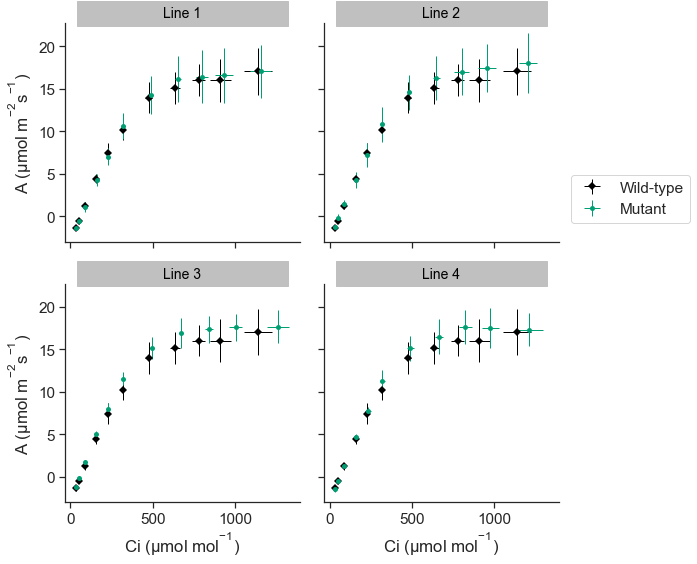

In [4]:
# sns.plotting_context()
sns.set(font_scale = 1.4, font="Arial")
sns.set_style(style='ticks')

# Choose hue colour palette
colours = ['#000000', '#009E73']

grid = sns.FacetGrid(grouped_df, col="plot", col_order=['1.10.18', '1.10.19', '1.10.32', '1.12.2'], hue="type", hue_order=['wt', 'mutant'],
                     palette=colours, col_wrap=2, size=4, aspect=1, hue_kws=dict(marker=["D", "o"]))

grid.map(plt.errorbar, "Ci_mean", "A_mean", "A_std", "Ci_std", markersize=5, linewidth=1.2, linestyle='', elinewidth=1, capsize=1, 
        markeredgecolor='black', markeredgewidth=0)


# Adjust position abd labels of legend
legend_ax = grid.axes.flat[3]
handles, labels = legend_ax.get_legend_handles_labels()
leg = plt.legend(handles[0:2],['Wild-type', 'Mutant'], bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)


# Set axis labels
grid.set_axis_labels(x_var="Ci ($\mu$mol mol$^{-1}$)", y_var="A ($\mu$mol m$^{-2}$s$^{-1}$)")


# Set titles 
# grid.set_titles("{col_name}")
axes = grid.axes.flatten()
axes[0].set_title("Line 1")
axes[1].set_title("Line 2")
axes[2].set_title("Line 3")
axes[3].set_title("Line 4")

for ax in grid.axes:
    # set the title position to the horizontal center (0.5) of the axes
    title = ax.set_title(ax.get_title(), position=(.5, 1.0), backgroundcolor="silver", color='black', 
                         size=14)
    # set the box style of the title text box to our custom box
    bb = title.get_bbox_patch()
    # use the axes' width as width of the text box
    bb.set_boxstyle("ext", pad=0.4, width=ax.get_window_extent().width )

plt.savefig("../figures/aciCurves.pdf", transparent=True, dpi=300, bbox_inches='tight')

#### Plot stomatal conductance against Ci

/Users/rona/miniconda3/envs/relocalisations_C4/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


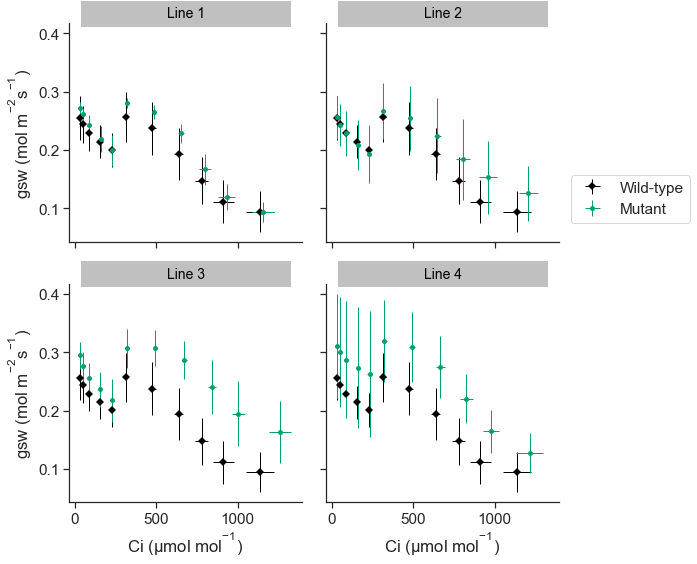

In [5]:
# sns.plotting_context()
sns.set(font_scale = 1.4, font="Arial")
sns.set_style(style='ticks')

# Choose hue colour palette
colours = ['#000000', '#009E73']

grid = sns.FacetGrid(grouped_df, col="plot", col_order=['1.10.18', '1.10.19', '1.10.32', '1.12.2'], hue="type", hue_order=['wt', 'mutant'],
                     palette=colours, col_wrap=2, size=4, aspect=1, hue_kws=dict(marker=["D", "o"]))

grid.map(plt.errorbar, "Ci_mean", "gsw_mean", "gsw_std", "Ci_std", markersize=5, linewidth=1.2, linestyle='', elinewidth=1, capsize=1, 
        markeredgecolor='black', markeredgewidth=0)


# Adjust position abd labels of legend
legend_ax = grid.axes.flat[3]
handles, labels = legend_ax.get_legend_handles_labels()
leg = plt.legend(handles[0:2],['Wild-type', 'Mutant'], bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)


# Set axis labels
grid.set_axis_labels(x_var="Ci ($\mu$mol mol$^{-1}$)", y_var="gsw (mol m$^{-2}$s$^{-1}$)")

# Set titles 
# grid.set_titles("{col_name}")
axes = grid.axes.flatten()
axes[0].set_title("Line 1")
axes[1].set_title("Line 2")
axes[2].set_title("Line 3")
axes[3].set_title("Line 4")

for ax in grid.axes:
    # set the title position to the horizontal center (0.5) of the axes
    title = ax.set_title(ax.get_title(), position=(.5, 1.0), backgroundcolor="silver", color='black', 
                         size=14)
    # set the box style of the title text box to our custom box
    bb = title.get_bbox_patch()
    # use the axes' width as width of the text box
    bb.set_boxstyle("ext", pad=0.4, width=ax.get_window_extent().width )

plt.savefig("../figures/CigswCurves.pdf", transparent=True, dpi=300, bbox_inches='tight')

#### t-test to test the null hypothesis that there is no difference in maximum rate of carbon assimilation 

In [10]:
CO2_conc = 1500

for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    t_test = stats.ttest_ind(aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'wt')]['A'].to_list(),
                             aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'mutant')]['A'].to_list(), 
                             equal_var=True)
    
    print(line)
    print(t_test.pvalue)

1.10.18
0.9953714623213051
1.10.19
0.6317289692176347
1.10.32
0.702178519466945
1.12.2
0.8620038752472984


In [12]:
CO2_conc = 1500

for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    t_test = stats.ttest_ind(aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'wt')]['Ci'].to_list(),
                             aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'mutant')]['Ci'].to_list(), 
                             equal_var=True)
    
    print(line)
    print(t_test)

1.10.18
Ttest_indResult(statistic=-0.3728441359020536, pvalue=0.7189492249348903)
1.10.19
Ttest_indResult(statistic=-1.5045174659964389, pvalue=0.17086132527084502)
1.10.32
Ttest_indResult(statistic=-2.3511907570959996, pvalue=0.05099804118091095)
1.12.2
Ttest_indResult(statistic=-1.3269605378240992, pvalue=0.22616768671318996)


#### t-test to test the null hypothesis that there is no difference in maximum stomatal conductance

In [13]:
CO2_conc = 1500

for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    t_test = stats.ttest_ind(aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'wt')]['gsw'].to_list(),
                             aci_df[(aci_df['plot'] == line) & (aci_df['CO2_r_sp'] == CO2_conc) & (aci_df['type'] == 'mutant')]['gsw'].to_list(), 
                             equal_var=True)
    
    print(line)
    print(t_test)

1.10.18
Ttest_indResult(statistic=0.024795972826539885, pvalue=0.9808250536796121)
1.10.19
Ttest_indResult(statistic=-1.1996643548556751, pvalue=0.264590386666656)
1.10.32
Ttest_indResult(statistic=-2.33841578921845, pvalue=0.051966014018142326)
1.12.2
Ttest_indResult(statistic=-1.4273897663825792, pvalue=0.19651797399744692)


In [29]:
aci_df_2 = aci_df[(aci_df['Fo'] != 0) & (aci_df['Fm'] != 0)]
for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    print(aci_df_2[(aci_df_2['plot'] == line) & (aci_df_2['type'] == 'mutant')]['Fm'].unique())
    print(aci_df_2[(aci_df_2['plot'] == line) & (aci_df_2['type'] == 'mutant')]['Fo'].unique())

[857.006 814.844 777.263 728.463 608.214]
[248.5315385 245.7192    222.6028    202.0546154 175.8368   ]
[573.64  694.091 946.623 619.758]
[164.7332    197.166     246.1588462 169.612    ]
[880.222 617.695]
[260.1692308 178.3611538]
[749.935 962.104 743.846 806.174]
[243.5816    234.4676    198.9836    204.6188462]


In [28]:
grouped_df = aci_df.groupby(['plant', 'type', 'line']).agg({'A': ['max']})
grouped_df.columns = ['A_max']
grouped_df = grouped_df.reset_index()

### Comparing A max (maximum A across whole ACi curve) across lines

In [35]:
# Test for significant difference in Amax between individual lines and wild-type
for line in ['1.10.18', '1.10.19', '1.10.32', '1.12.2']:
    t_test = stats.ttest_ind(grouped_df[(grouped_df['line'] == line)]['A_max'].to_list(),
                             grouped_df[(grouped_df['line'] == 'wt')]['A_max'].to_list(), 
                             equal_var=True)
    print(line)
    print(t_test)

1.10.18
Ttest_indResult(statistic=0.04700738597641924, pvalue=0.9636596355617224)
1.10.19
Ttest_indResult(statistic=0.6211306382905806, pvalue=0.55179631093271)
1.10.32
Ttest_indResult(statistic=0.47002656304067036, pvalue=0.6526273799103179)
1.12.2
Ttest_indResult(statistic=0.6175887596196146, pvalue=0.5540150314415394)


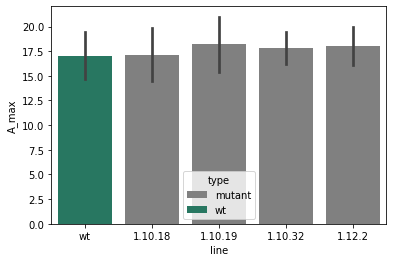

In [37]:
# Corresponding plot
colours = ['gray', '#009E73']
ax = sns.barplot(x="line", y='A_max', hue="type", data=grouped_df, dodge=False, ci='sd', palette=colours, saturation=0.5,
            order=['wt', '1.10.18', '1.10.19', '1.10.32', '1.12.2'])

In [39]:
# Test for significant difference in Amax between all mutants and wild-type

t_test = stats.ttest_ind(grouped_df[(grouped_df['type'] == 'mutant')]['A_max'].to_list(),
                         grouped_df[(grouped_df['line'] == 'wt')]['A_max'].to_list(), 
                         equal_var=True)
print(t_test)

Ttest_indResult(statistic=0.586698444271266, pvalue=0.5633787909516607)


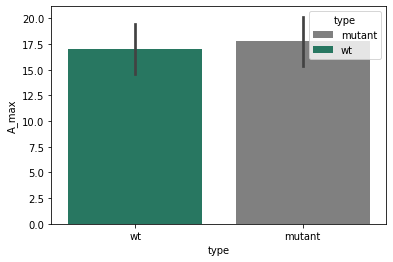

In [40]:
# Corresponding plot
colours = ['gray', '#009E73']
ax = sns.barplot(x="type", y='A_max', hue="type", data=grouped_df, dodge=False, ci='sd', palette=colours, saturation=0.5,
            order=['wt', 'mutant'])